# Greg

# James

In [1]:
#Imports
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string

Data Bases
rt.movie_info.tsv.gz
bom.movie_gross.csv.gz

In [2]:
!ls zippedData

bom.movie_gross.csv.gz
im.db
im.db.zip
rt.movie_info.tsv.gz
rt.reviews.tsv.gz
tmdb.movies.csv.gz
tn.movie_budgets.csv.gz


In [37]:
#Read the data frame
tn_movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
#Clean columns into floats into floats
tn_movie_budgets["production_budget"] = tn_movie_budgets["production_budget"].map(lambda x : float(x.replace("$","").replace(",","")))
tn_movie_budgets["domestic_gross"] = tn_movie_budgets["domestic_gross"].map(lambda x : float(x.replace("$","").replace(",","")))
tn_movie_budgets["worldwide_gross"] = tn_movie_budgets["worldwide_gross"].map(lambda x : float(x.replace("$","").replace(",","")))
#Creates a date time from release date
tn_movie_budgets["release_date"]=pd.to_datetime(tn_movie_budgets["release_date"])
#Creates a new title column
tn_movie_budgets["title"]= tn_movie_budgets["movie"].map(lambda x :''.join(filter(str.isalnum, x)).lower())

tn_movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,title
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,avatar
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,piratesofthecaribbeanonstrangertides
2,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,darkphoenix
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,avengersageofultron
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,starwarsepviiithelastjedi


In [5]:
tn_movie_budgets["return"] =tn_movie_budgets["worldwide_gross"] -  tn_movie_budgets["production_budget"]  
tn_movie_budgets.describe()

,id,production_budget,domestic_gross,worldwide_gross,return
count,5782.000000,5.782000e+03,5.782000e+03,5.782000e+03,5.782000e+03
mean,50.372363,3.158776e+07,4.187333e+07,9.148746e+07,5.989970e+07
std,28.821076,4.181208e+07,6.824060e+07,1.747200e+08,1.460889e+08
min,1.000000,1.100000e+03,0.000000e+00,0.000000e+00,-2.002376e+08
25%,25.000000,5.000000e+06,1.429534e+06,4.125415e+06,-2.189071e+06
50%,50.000000,1.700000e+07,1.722594e+07,2.798445e+07,8.550286e+06
75%,75.000000,4.000000e+07,5.234866e+07,9.764584e+07,6.096850e+07
max,100.000000,4.250000e+08,9.366622e+08,2.776345e+09,2.351345e+09


In [6]:
#gets basic stats 
tmdb_movies = pd.read_csv('zippedData/tmdb.movies.csv.gz')
tmdb_movies.describe()


,Unnamed: 0,id,popularity,vote_average,vote_count
count,26517.00000,26517.000000,26517.000000,26517.000000,26517.000000
mean,13258.00000,295050.153260,3.130912,5.991281,194.224837
std,7654.94288,153661.615648,4.355229,1.852946,960.961095
min,0.00000,27.000000,0.600000,0.000000,1.000000
25%,6629.00000,157851.000000,0.600000,5.000000,2.000000
50%,13258.00000,309581.000000,1.374000,6.000000,5.000000
75%,19887.00000,419542.000000,3.694000,7.000000,28.000000
max,26516.00000,608444.000000,80.773000,10.000000,22186.000000


In [7]:
rt_reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', delimiter = "\t", encoding = "unicode_escape")
rt_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


In [8]:
rt_movie_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', delimiter = "\t")
rt_movie_info

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1555,1996,Forget terrorists or hijackers -- there's a ha...,R,Action and Adventure|Horror|Mystery and Suspense,NaN,NaN,"Aug 18, 2006","Jan 2, 2007",$,"33,886,034",106 minutes,New Line Cinema
1556,1997,The popular Saturday Night Live sketch was exp...,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,NaN,88 minutes,Paramount Vantage
1557,1998,"Based on a novel by Richard Powell, when the l...",G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,NaN,"Jan 1, 1962","May 11, 2004",NaN,NaN,111 minutes,NaN
1558,1999,The Sandlot is a coming-of-age story about a g...,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993","Jan 29, 2002",NaN,NaN,101 minutes,NaN


In [9]:
movie_gross_db = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
movie_gross_db.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [10]:
conn = sqlite3.connect("zippedData/im.db")

pd.read_sql("""
SELECT name FROM sqlite_master  
  WHERE type='table'
""", conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [25]:
q = """
SELECT * FROM movie_ratings
JOIN movie_basics
    ON movie_ratings.movie_id = movie_basics.movie_id

"""

pd.read_sql(q, conn)

#movie basics has 150k rows, movie basics has 73k

,movie_id,averagerating,numvotes,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt10356526,8.3,31,tt10356526,Laiye Je Yaarian,Laiye Je Yaarian,2019,117.0,Romance
1,tt10384606,8.9,559,tt10384606,Borderless,Borderless,2019,87.0,Documentary
2,tt1042974,6.4,20,tt1042974,Just Inès,Just Inès,2010,90.0,Drama
3,tt1043726,4.2,50352,tt1043726,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy"
4,tt1060240,6.5,21,tt1060240,Até Onde?,Até Onde?,2011,73.0,"Mystery,Thriller"
...,...,...,...,...,...,...,...,...,...
73851,tt9805820,8.1,25,tt9805820,Caisa,Caisa,2018,84.0,Documentary
73852,tt9844256,7.5,24,tt9844256,Code Geass: Lelouch of the Rebellion - Glorifi...,Code Geass: Lelouch of the Rebellion Episode III,2018,120.0,"Action,Animation,Sci-Fi"
73853,tt9851050,4.7,14,tt9851050,Sisters,Sisters,2019,NaN,"Action,Drama"
73854,tt9886934,7.0,5,tt9886934,The Projectionist,The Projectionist,2019,81.0,Documentary


<AxesSubplot:xlabel='production_budget', ylabel='domestic_gross'>

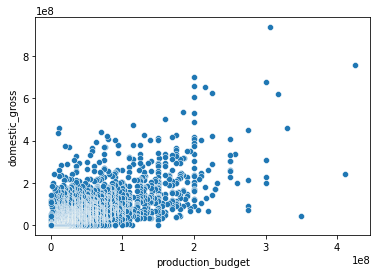

In [12]:
sns.scatterplot(x = tn_movie_budgets["production_budget"], y = tn_movie_budgets["domestic_gross"])


In [13]:
tn_movie_budgets.corr()

,id,production_budget,domestic_gross,worldwide_gross,return
id,1.000000,-0.035278,0.008255,-0.009422,-0.001172
production_budget,-0.035278,1.000000,0.685682,0.748306,0.608752
domestic_gross,0.008255,0.685682,1.000000,0.938853,0.926605
worldwide_gross,-0.009422,0.748306,0.938853,1.000000,0.981811
return,-0.001172,0.608752,0.926605,0.981811,1.000000


Genre Testing

In [60]:
q = """
SELECT * FROM movie_basics
"""
#create a DF from the IMBD sql table
imdb_movie_ratings = pd.read_sql(q, conn)
imdb_movie_ratings

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [91]:
#create a column for movie names to merge with other DFs   tn_movie_budgets
imdb_movie_ratings['title'] = imdb_movie_ratings['primary_title'].map(lambda x :''.join(filter(str.isalnum, x)).lower())

tn_movie_budgets.set_index('title', inplace=True)
imdb_movie_ratings.set_index('title', inplace=True)
imdb_movie_ratings.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
title,,,,,,
sunghursh,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
onedaybeforetherainyseason,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
theothersideofthewind,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
sabsebadasukh,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
thewanderingsoapopera,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [92]:
#join new imdb with the numbers table
#tn_movie_budgets.set_index('title', inplace=True)

#combine imdb and the numbers tables
rating_and_budgets = tn_movie_budgets.join(imdb_movie_ratings, how = 'inner')
rating_and_budgets.reset_index(inplace=True)
rating_and_budgets = rating_and_budgets.drop_duplicates(subset='title', keep="first")
rating_and_budgets

,title,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,10cloverfieldlane,54,2016-03-11,10 Cloverfield Lane,5000000.0,72082999.0,1.082864e+08,tt1179933,10 Cloverfield Lane,10 Cloverfield Lane,2016,103.0,"Drama,Horror,Mystery"
1,10daysinamadhouse,48,2015-11-11,10 Days in a Madhouse,12000000.0,14616.0,1.461600e+04,tt3453052,10 Days in a Madhouse,10 Days in a Madhouse,2015,111.0,Drama
2,127hours,6,2010-11-05,127 Hours,18000000.0,18335230.0,6.021717e+07,tt1542344,127 Hours,127 Hours,2010,94.0,"Adventure,Biography,Drama"
3,12rounds,37,2009-03-27,12 Rounds,20000000.0,12234694.0,1.730665e+07,tt3517850,12 Rounds,12 Rounds,2017,NaN,"Action,Drama,Romance"
4,12strong,64,2018-01-19,12 Strong,35000000.0,45819713.0,7.111838e+07,tt1413492,12 Strong,12 Strong,2018,130.0,"Action,Drama,History"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4043,zoolander2,64,2016-02-12,Zoolander 2,50000000.0,28848693.0,5.534869e+07,tt1608290,Zoolander 2,Zoolander 2,2016,101.0,Comedy
4044,zoom,26,2006-08-11,Zoom,35000000.0,11989328.0,1.250619e+07,tt3763866,Zoom,Zoom,2015,96.0,"Animation,Comedy,Drama"
4048,zootopia,57,2016-03-04,Zootopia,150000000.0,341268248.0,1.019430e+09,tt2948356,Zootopia,Zootopia,2016,108.0,"Adventure,Animation,Comedy"
4049,zstorm,64,2015-08-18,Z Storm,7000000.0,0.0,2.053330e+06,tt3469440,Z Storm,Z fung bou,2014,92.0,"Action,Crime"


# Han

# Rachel

# Himansri